### <span style="color:#055C9D"> Installation of the libraries:  </span> 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from lightgbm.sklearn import LGBMRegressor

### <span style="color:#055C9D"> Validation function:  </span>  
Input: 
- X :sensors data [dataframe]
- y : plateforme's force z axis [serie]
- period : number of measure in one's passage
Output: 
- score of the model trained 
- mean squared error of the model 
- prediction obtained

In [2]:
from sklearn.metrics import mean_squared_error
def exceptOneValidation(model,X,y,period=5000):
    score=[]
    predict=[]
    error=[]
    for i in range(0,len(X),period):
        if i==0:
            X_train=X.iloc[period:,:]
            y_train=y.iloc[period:]
            X_test=X.iloc[0:period,:]
            y_test=y.iloc[0:period]
        elif i==len(X)-period:
            X_train=X.iloc[0:i,:]
            y_train=y.iloc[0:i]
            X_test=X.iloc[i:i+period,:]
            y_test=y.iloc[i:i+period]
        else:
            X_train=pd.concat([X.iloc[0:i,:],X.iloc[i+period:,:]],axis=0)
            y_train=pd.concat([y.iloc[0:i],y.iloc[i+period:]],axis=0)
            X_test=X.iloc[i:i+period,:]
            y_test=y.iloc[i:i+period]
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        predict=np.concatenate([predict,y_pred])
        score.append(model.score(X_test,y_test))
        error.append(mean_squared_error(y_test,y_pred))
    return score,error,predict

### <span style="color:#055C9D"> Implementation of the input dataset:  </span>
Loading the data (after the conversion from matlab format):  

In [4]:
data=pd.read_csv("data.csv")
df=data.copy()

Adding variation as input data:   
*We wanted to add as input a parameter representing the variation between the 2 last measures, as the gap between thos 2 can be really realevant.*


In [5]:
def get_variation(df):
    
    x_lum_var=df.x_lumbar-df.x_lumbar.shift(periods=1, fill_value=df.x_lumbar[len(df)-1])
    y_lum_var=df.y_lumbar-df.y_lumbar.shift(periods=1, fill_value=df.y_lumbar[len(df)-1])
    z_lum_var=df.z_lumbar-df.z_lumbar.shift(periods=1, fill_value=df.z_lumbar[len(df)-1])
    x_tib_var=df.x_tibia-df.x_tibia.shift(periods=1, fill_value=df.x_tibia[len(df)-1])
    y_tib_var=df.y_tibia-df.y_tibia.shift(periods=1, fill_value=df.y_tibia[len(df)-1])
    z_tib_var=df.z_tibia-df.z_tibia.shift(periods=1, fill_value=df.z_tibia[len(df)-1])

    df_var= pd.DataFrame(
    {'var_x_lumbar': x_lum_var,
     'var_y_lumbar': y_lum_var,
     'var_z_lumbar': z_lum_var,
     'var_x_tibia': x_tib_var,
     'var_y_tibia': y_tib_var,
     'var_z_tibia': z_tib_var
    })
    
    return df.join(df_var)

In [6]:
df=get_variation(df)
X=df.drop(['index','nb_seance','nb_passage','x_force','z_force','y_force'],axis=1)
y=df['z_force']

### <span style="color:#055C9D"> Running the model on the dataset :  </span>  

In [7]:
lgbmr=LGBMRegressor(boosting_type='goss',random_state=42,n_estimators=300,learning_rate=0.2,n_jobs=-1)
score_lgbmr,error_lgbmr,predict_lgbmr=exceptOneValidation(lgbmr,X,y)

### <span style="color:#055C9D"> Results :  </span> 

In [8]:
import math 
print('MSE:',math.sqrt(pd.Series(error_lgbmr).mean()))
print('Score:',pd.Series(score_lgbmr).mean()*100,'%')

MSE: 49.7642552745276
Score: 99.06408178253949 %


In [9]:
pd.Series(error_lgbmr).describe()

count      100.000000
mean      2476.481103
std       3381.177541
min        250.547832
25%       1094.695220
50%       1552.306824
75%       2603.078681
max      24238.511166
dtype: float64

In [10]:

pd.Series(score_lgbmr).describe()

count    100.000000
mean       0.990641
std        0.012723
min        0.913530
25%        0.990214
50%        0.994020
75%        0.996027
max        0.999092
dtype: float64

### <span style="color:#055C9D"> Graph printing the results :  </span> 
Results are printed 5 by 5, we can observe that there is a lot of noise (deleted further in this document) and some big drop(we are seraching for a solution), but the result is quite satisfing.

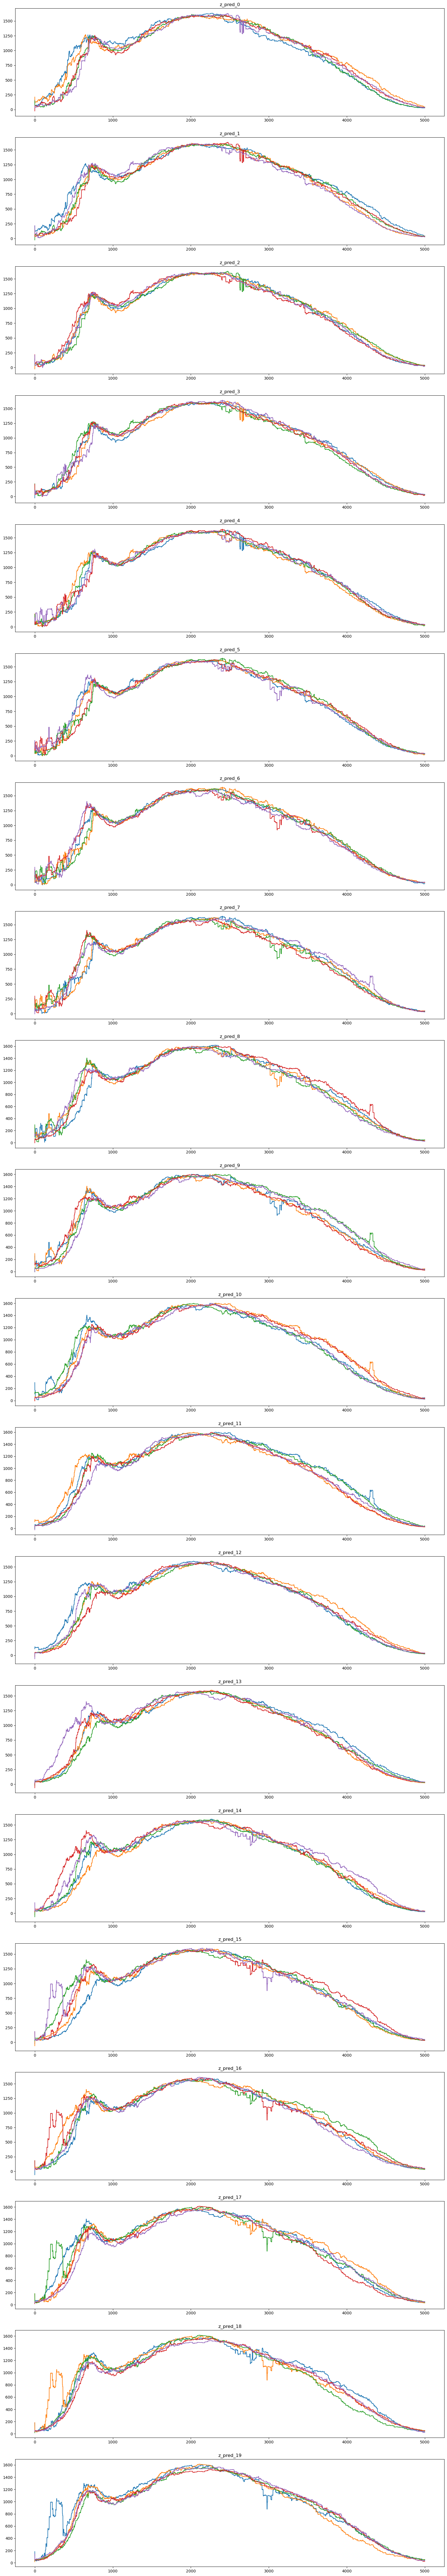

In [11]:
df['z_pred']=predict_lgbmr
fig,axes = plt.subplots(20,1,figsize=(20,120))
for i in range(20):
    df['z_pred'].iloc[i*5000:i*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred'].iloc[(i+1)*5000:(i+1)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred'].iloc[(i+2)*5000:(i+2)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred'].iloc[(i+3)*5000:(i+3)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred'].iloc[(i+4)*5000:(i+4)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')

### <span style="color:#055C9D"> Graph printing the results smooth :  </span> 

In [12]:

df['z_pred_smooth']=df['z_pred']
wind=201
windna=int((wind-1)/2)
for i in range(100):
    df['z_pred_smooth'].iloc[i*5000+windna:i*5000+5000-windna]=df['z_pred'].iloc[i*5000:i*5000+5000].rolling(wind,center=True).mean().iloc[windna:-windna]

C:\Users\mathi\AppData\Local\Temp\ipykernel_52492\194184079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_pred_smooth'].iloc[i*5000+windna:i*5000+5000-windna]=df['z_pred'].iloc[i*5000:i*5000+5000].rolling(wind,center=True).mean().iloc[windna:-windna]


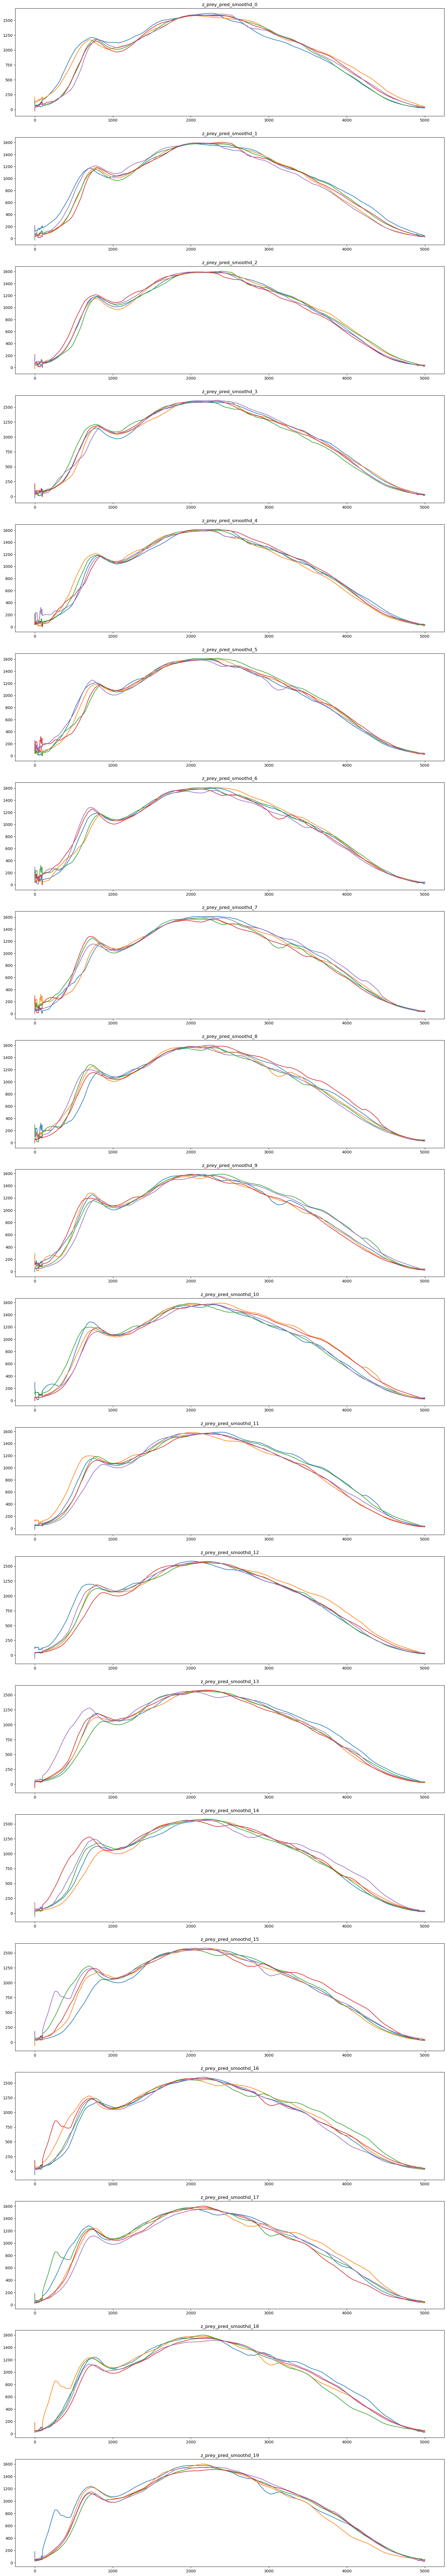

In [13]:
fig,axes = plt.subplots(20,1,figsize=(20,120))
for i in range(20):
    df['z_pred_smooth'].iloc[i*5000:i*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred_smooth'].iloc[(i+1)*5000:(i+1)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred_smooth'].iloc[(i+2)*5000:(i+2)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred_smooth'].iloc[(i+3)*5000:(i+3)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred_smooth'].iloc[(i+4)*5000:(i+4)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_prey_pred_smoothd_{i}')

### <span style="color:#055C9D"> Comparision of the result (not smooth/smooth) :  </span> 

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
print("MSE:")
print('Raw',mean_squared_error(df['z_force'],df['z_pred'])**(1/2),'Smooth:',mean_squared_error(df['z_force'],df['z_pred_smooth'])**(1/2))
print("Score:")
print('Raw',r2_score(df['z_force'],df['z_pred']),'Smooth:',r2_score(df['z_force'],df['z_pred_smooth']))

MSE:
Raw 49.7642552745276 Smooth: 44.98797055873512
Score:
Raw 0.9906619639735907 Smooth: 0.9923684398562059


### <span style="color:#055C9D"> Export the prediction in CSV file </span> 

In [25]:
np.savetxt("Exported_data\data_predict.csv", predict_lgbmr, delimiter=",")